In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

## Homework 1

#### Due 9/29

#### 30 parts, each part worth 1 point

### Linear Regression Analysis of hw1 dataset

#### 1. Read in hw1.csv 

In [3]:
df = pd.read_csv("hw1.csv") 
df.tail()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193
76,Wheaties_Honey_Gold,G,C,110,2,1,200,1.0,16.0,8,60,25,1,1.0,0.75,36.187559


 #### The fields in the dataset are:
 
* name: Name of cereal  
* mfr: Manufacturer of cereal (A = American Home Food Products, G = General Mills, K = Kelloggs, N = Nabisco, P = Post, Q = Quaker Oats, R = Ralston Purina  
* type: C: cold H:hot  
* calories: calories per serving   
* protein: grams of protein 
* fat: grams of fat 
* sodium: milligrams of sodium   
* fiber: grams of dietary fiber   
* carbo: grams of complex carbohydrates   
* sugars: grams of sugars   
* potass: milligrams of potassium   
* vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended   
* shelf: display shelf (1, 2, or 3, counting from the floor)   
* weight: weight in ounces of one serving   
* cups: number of cups in one serving   
* rating: a rating of the cereals (Possibly from Consumer Reports?)  



### Goal of the analysis

The goal of this linear regression model to to predict the customer rating of the cereals based on the features given in the columns. We want the simplest model that explains the data.

The first step is an exploratory analysis. Looking a the features listed above, lets eliminate name, type,weight and cups from the model. 

#### 2. Recreate a new dataframe without name, type,weight and cups 

In [4]:
df = df.loc[:,['mfr','calories', 'protein', 'fat', 'sodium', 'fiber', 
       'carbo', 'sugars', 'potass', 'vitamins', 'shelf','rating']]
df.head()

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,rating
0,N,70,4,1,130,10.0,5.0,6,280,25,3,68.402973
1,Q,120,3,5,15,2.0,8.0,8,135,0,3,33.983679
2,K,70,4,1,260,9.0,7.0,5,320,25,3,59.425505
3,K,50,4,0,140,14.0,8.0,0,330,25,3,93.704912
4,R,110,2,2,200,1.0,14.0,8,-1,25,3,34.384843


### Clean the data.

Notice that potass has a value of -1 which clearly is not valid.

#### 3. Do any other columns have -1?

In [5]:
for var in df.columns:
    if any(df.loc[:,var] == -1):
        print(var)
        

carbo
sugars
potass


#### 4. Replace negative values in carbo,sugars and potass with np.NaN


In [6]:
df.replace({'carbo':-1,'sugars':-1,'potass':-1},np.NaN,inplace=True)
df.head()

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,rating
0,N,70,4,1,130,10.0,5.0,6.0,280.0,25,3,68.402973
1,Q,120,3,5,15,2.0,8.0,8.0,135.0,0,3,33.983679
2,K,70,4,1,260,9.0,7.0,5.0,320.0,25,3,59.425505
3,K,50,4,0,140,14.0,8.0,0.0,330.0,25,3,93.704912
4,R,110,2,2,200,1.0,14.0,8.0,NaN,25,3,34.384843


#### 5. Check for null values

In [7]:
df.isnull().sum()

mfr         0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       1
sugars      1
potass      2
vitamins    0
shelf       0
rating      0
dtype: int64

#### 6. Drop rows with null values

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

mfr         0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
rating      0
dtype: int64

### Descriptive Statistics

#### 7. Summarize the data with the pandas describe function

In [9]:
df.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,rating
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,107.027027,2.513514,1.000000,162.364865,2.175676,14.729730,7.108108,98.513514,29.054054,2.216216,42.371787
std,19.843893,1.075802,1.006826,82.769787,2.423391,3.891675,4.359111,70.878681,22.294352,0.832067,14.033712
min,50.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,15.000000,0.000000,1.000000,18.042851
25%,100.000000,2.000000,0.000000,135.000000,0.250000,12.000000,3.000000,41.250000,25.000000,1.250000,32.449210
50%,110.000000,2.500000,1.000000,180.000000,2.000000,14.500000,7.000000,90.000000,25.000000,2.000000,40.253087
75%,110.000000,3.000000,1.000000,217.500000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,50.520610
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,93.704912


#### Lets look at levels of the categorical variable shelp


In [10]:
df.groupby(by=['shelf']).median()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,rating
shelf,,,,,,,,,,
1,110,2,0,200,1.5,16.0,3.0,70.0,25,41.998933
2,110,2,1,165,0.0,13.0,12.0,45.0,25,30.577169
3,110,3,1,170,3.0,15.0,6.0,110.0,25,40.917047


#### 8. Create a boxplot for rating as a function of shelf

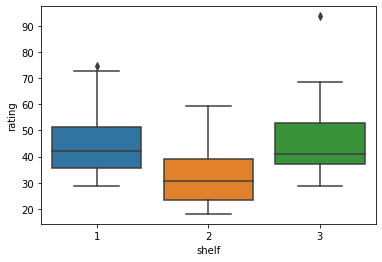

In [11]:
sns.boxplot(x='shelf',y='rating',data=df);

#### 9. Create a seaborn pairplot of all the variables with a 'kde' diagonal

This will take some time to execute

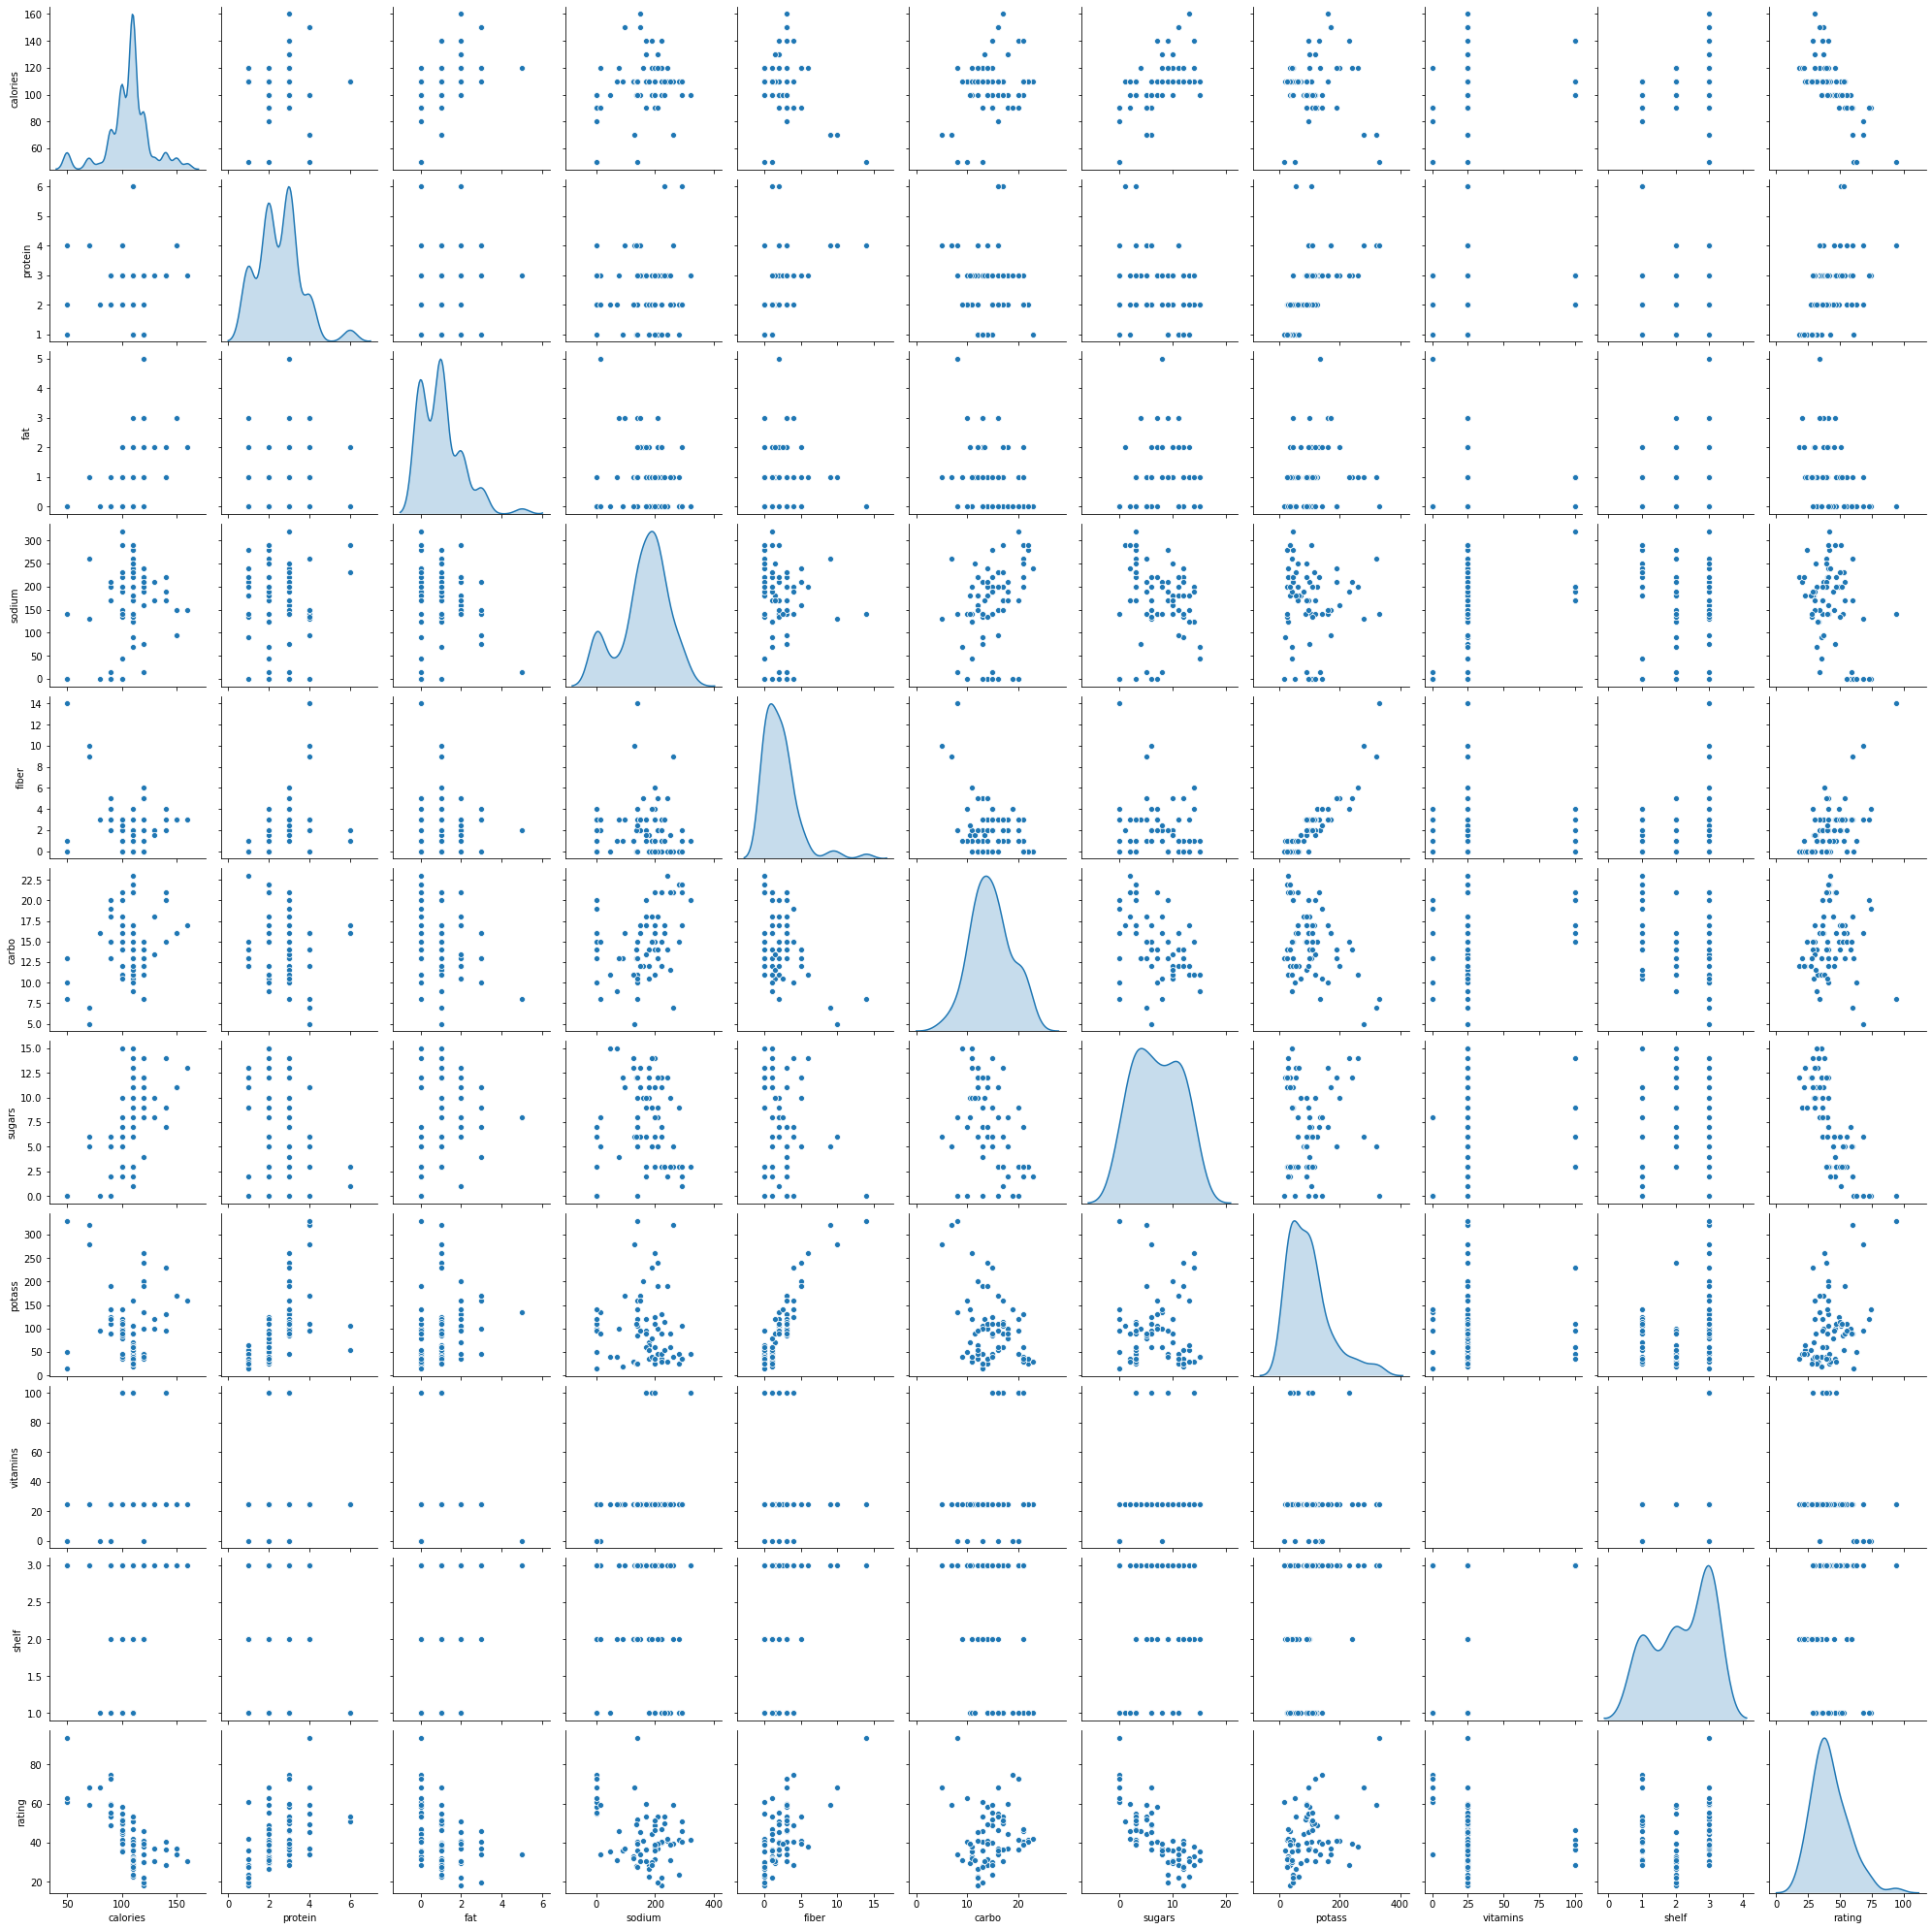

In [191]:
sns.pairplot(df, diag_kind='kde');

#### 10. Create a correlation matrix for all the non-categorical variables

In [13]:
df2 = df.drop('shelf',axis=1)
df2.corr()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,rating
calories,1.000000,0.033992,0.507373,0.296247,-0.295212,0.270606,0.569121,-0.071361,0.259846,-0.693785
protein,0.033992,1.000000,0.202353,0.011559,0.514006,-0.036743,-0.286584,0.578743,0.054800,0.467162
fat,0.507373,0.202353,1.000000,0.000822,0.014036,-0.284934,0.287152,0.199637,-0.030514,-0.405050
sodium,0.296247,0.011559,0.000822,1.000000,-0.070735,0.328409,0.037059,-0.039438,0.331576,-0.383012
fiber,-0.295212,0.514006,0.014036,-0.070735,1.000000,-0.379084,-0.150949,0.911504,-0.038717,0.603411
carbo,0.270606,-0.036743,-0.284934,0.328409,-0.379084,1.000000,-0.452069,-0.365003,0.253579,0.055941
sugars,0.569121,-0.286584,0.287152,0.037059,-0.150949,-0.452069,1.000000,0.001414,0.072954,-0.755955
potass,-0.071361,0.578743,0.199637,-0.039438,0.911504,-0.365003,0.001414,1.000000,-0.002636,0.415782
vitamins,0.259846,0.054800,-0.030514,0.331576,-0.038717,0.253579,0.072954,-0.002636,1.000000,-0.214481
rating,-0.693785,0.467162,-0.405050,-0.383012,0.603411,0.055941,-0.755955,0.415782,-0.214481,1.000000


#### 11. Create a seaborn distribution plot of rating

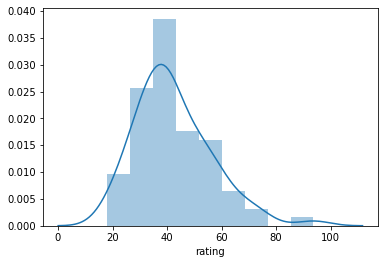

In [208]:
sns.distplot(df.rating);

### Data Preprocessing & Model

#### 12-21 Run model function

To facilitate running the Linear Regression multiple times, complete the code in the function below.

In [217]:
def run_model(df, target, feats,feats_scale=False):  
    ''' Parameters:
            df: the dataframe containing the features and the target
            target: the target variable name as a string
            feats: a list of feature names as strings
            feats_scale: a list of feature names as strings to scale or none
        Returns:
            the intercept, coefficient(s), predictions, y_test and R-squared
        '''
    
    X = df.loc[:,feats].values
    y = df.loc[:,target].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    if feats_scale:
        scaler = StandardScaler()
        scale_idxs = list(map(feats.index,feats_scale)) 
        X_train[:,scale_idxs] = scaler.fit_transform(X_train[:,scale_idxs])
        X_test[:,scale_idxs] = scaler.transform(X_test[:,scale_idxs])

    model = LinearRegression()
    model.fit(X_train, y_train)

    yhat = model.predict(X_test)
    r2 = model.score(X_test,y_test)
    return (model.intercept_,model.coef_, yhat, y_test,r2)
 

### Simple Linear Regression


#### 22. Run a simple linear regression with sugars as the predictor (i.e. feature)

In [269]:
feats = ['sugars'] 

feats_scale = ['sugars']

target = 'rating'

In [270]:
b0,b1,yhat,y_test,R2 = run_model(df,target,feats,feats_scale)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 1) (15, 1) (59,) (15,)
Intercept: 43.08698896610169 
Coefs: [-11.06794035]
R^2: 0.5480982530959383 


#### 23.  Rerun model in 1.13. 

Notice the difference in the returns. Run a few times with and without scaling

In [272]:
b0,b1,yhat,y_test,R2 = run_model(df,target,feats)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 1) (15, 1) (59,) (15,)
Intercept: 57.525456538882054 
Coefs: [-2.15058543]
R^2: 0.6035134909489606 


#### 24. Plot the residuals

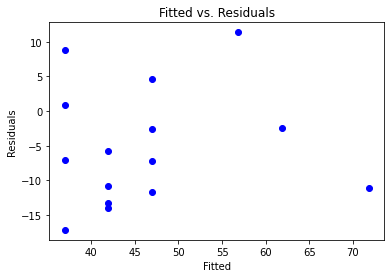

In [216]:
plt.plot(yhat,y_test-yhat,'bo')
plt.title("Fitted vs. Residuals")
plt.xlabel("Fitted")
plt.ylabel("Residuals");

### Multiple Linear Regression

#### 25. Encode the  shelf variable so that there is no dummy variable trap.

In [219]:
df.shelf.unique()

array([3, 1, 2])

In [220]:
df2=pd.get_dummies(df,columns=['shelf'],drop_first=True) # Your code here
df2.head()

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,rating,shelf_2,shelf_3
0,N,70,4,1,130,10.0,5.0,6.0,280.0,25,68.402973,0,1
1,Q,120,3,5,15,2.0,8.0,8.0,135.0,0,33.983679,0,1
2,K,70,4,1,260,9.0,7.0,5.0,320.0,25,59.425505,0,1
3,K,50,4,0,140,14.0,8.0,0.0,330.0,25,93.704912,0,1
5,G,110,2,2,180,1.5,10.5,10.0,70.0,25,29.509541,0,0


#### 26. Run Multiple Linear Regression with calories, fat, sugar and shelf as predictors

In [254]:
feats = ['calories','fat','sugars','shelf_2','shelf_3']
feats_scale = ['calories','fat','sugars']
b0,b1,yhat,y_test,R2 = run_model(df2,target,feats,feats_scale)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 5) (15, 5) (59,) (15,)
Intercept: 39.926190261727584 
Coefs: [-5.9459531  -1.15897251 -5.66467313  0.24680803  5.87432349]
R^2: 0.6827858900140849 


#### 27. Calculate the root Mean Square Error

In [233]:
def rmse(y,yhat):
    return np.sqrt(np.mean((y - yhat)**2))

rmse(y_test,yhat)

6.853727291415419

#### 28. Run Multiple Linear Regression with calories, fat, sugar and carbo as predictors


In [255]:
feats = ['calories','fat','sugars','carbo']
feats_scale = ['calories','fat','sugars','carbo']
b0,b1,yhat,y_test,R2 = run_model(df2,target,feats,feats_scale)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 4) (15, 4) (59,) (15,)
Intercept: 42.09164427118643 
Coefs: [  7.48501873  -7.39061506 -17.96672924 -10.01829303]
R^2: 0.6396617252061828 


#### 29. Run Multiple Linear Regression with all the predictors except mfr. 

In [243]:
df2.columns

Index(['mfr', 'calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo',
       'sugars', 'potass', 'vitamins', 'rating', 'shelf_2', 'shelf_3'],
      dtype='object')

In [259]:
feats = ['calories', 'fat', 'sodium', 'fiber', 'carbo',
       'sugars', 'potass', 'vitamins', 'shelf_2', 'shelf_3']
feats_scale = ['calories', 'fat', 'sodium', 'fiber', 'carbo',
       'sugars', 'potass', 'vitamins']

b0,b1,yhat,y_test,R2 = run_model(df2,target,feats,feats_scale)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 10) (15, 10) (59,) (15,)
Intercept: 43.33024914054771 
Coefs: [ 0.74002613 -3.51495935 -4.58613385  5.36485293 -0.12961045 -8.78793232
  1.10603802 -0.6008659  -1.14590748 -1.61838789]
R^2: 0.9584524289566004 


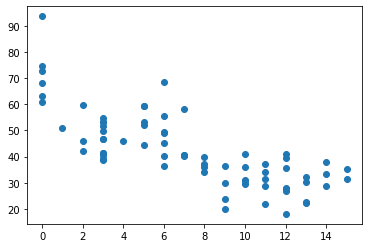

In [248]:
plt.plot(df2.sugars,df2.rating,'o');

### Polynomial Linear Regression

####  30. Add a sugars squared variable to the data frame and run model with sugars and sugars squared

In [266]:
df2['sugars2'] = df2.sugars.values**2

In [268]:
feats = ['sugars','sugars2']
feats_scale = ['sugars','sugars2']
b0,b1,yhat,y_test,R2 = run_model(df2,target,feats,feats_scale)
print(f'Intercept: {b0} \nCoefs: {b1}\nR^2: {R2} ')

(59, 2) (15, 2) (59,) (15,)
Intercept: 41.405201610169485 
Coefs: [-13.57392758   4.36763431]
R^2: 0.630243487645694 
